In [1]:
import csv
import json
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.spatial import Delaunay
from igraph import *
import matplotlib.pyplot as plt
import json
import numpy as np
import os
import random
import math

### Q6

#### create graph

In [2]:
directory = os.path.abspath('/Users/bournsh/Desktop/UCLA_Studying/2020spring/ECE232/Project4/data/test_data')#
df = pd.read_csv(directory + '/san_francisco-censustracts-2017-4-All-MonthlyAggregate.csv')

In [3]:
df = df.iloc[:, 0:4]
df = df.loc[df['month']==12]
dec_df = df.drop(['month'], axis=1)


In [4]:
dec_df.head()

,sourceid,dstid,mean_travel_time
0,1982,73,350.59
1,2213,1523,872.92
2,438,433,2262.35
3,448,333,1337.10
6,2231,315,805.52


In [5]:
init_dec_df = dec_df.copy()
init_dec_df['sourceid'] = init_dec_df['sourceid'].astype(str)
init_dec_df['dstid'] = init_dec_df['dstid'].astype(str)


In [6]:
tuples_init = [tuple(x) for x in init_dec_df.values]
g_init = Graph.TupleList(tuples_init, directed = False, edge_attrs = 'weight')

In [7]:
summary(g_init)

IGRAPH UNW- 1905 555265 -- 
+ attr: name (v), weight (e)


#### clear the duplicates

In [8]:
dec_array = np.asarray(dec_df) 
existing_paths = {}
existing_locations = np.unique(np.concatenate([dec_array[:,0],dec_array[:,1]]))
counter = 0
for row in dec_array:
    locations = tuple(np.sort(row[0:2]))
    if locations in existing_paths:
        existing_paths[locations].append(row[2])
        counter += 1
    else:
        existing_paths[locations] = [row[2]]

with open(directory + '/december_data.txt','w') as f:
    for locations in existing_paths:
        string = '{} {} {:.2f}\n'.format(int(locations[0]),int(locations[1]),np.mean(existing_paths[locations]))
        f.write(string)

In [9]:
g = Graph.Read(directory + '/december_data.txt', format='ncol', directed=False)
gcc = g.components().giant()
summary(g)
summary(gcc)

IGRAPH UNW- 1905 321713 -- 
+ attr: name (v), weight (e)
IGRAPH UNW- 1898 321703 -- 
+ attr: name (v), weight (e)


#### get the json file

In [10]:
with open(directory+'/san_francisco_censustracts.json', 'r') as f:
    data_json = json.load(f)
data_json.keys()

dict_keys(['type', 'features'])

In [11]:
geo_df = data_json['features']

In [12]:
colname = ['ID', 'Display_Name', 'Longitude', 'Latitude']
map_df = pd.DataFrame(columns = colname)
map_df

,ID,Display_Name,Longitude,Latitude


In [13]:
print(geo_df[0].keys())
print(geo_df[0]['properties'].keys())
print(geo_df[0]['geometry'].keys())

dict_keys(['type', 'properties', 'geometry'])
dict_keys(['MOVEMENT_ID', 'DISPLAY_NAME'])
dict_keys(['type', 'coordinates'])


In [14]:
i = 1
for item in geo_df:
    map_df.loc[i, 'ID'] = item['properties']['MOVEMENT_ID']
    map_df.loc[i, 'Display_Name'] = item['properties']['DISPLAY_NAME']
    coors = item['geometry']['coordinates'][0][0]
    if isinstance(coors[0], list):
        longitude = 0
        latitude = 0

        for coor in coors:
            longitude = longitude+coor[0]
            latitude = latitude+coor[1]
            
        longitude = longitude/len(coors)
        latitude = latitude/len(coors)       
    else:
        coors = item['geometry']['coordinates'][0]
        longitude = 0
        latitude = 0

        for coor in coors:
            longitude = longitude+coor[0]
            latitude = latitude+coor[1]
            
        longitude = longitude/len(coors)
        latitude = latitude/len(coors) 
        
    map_df.loc[i, 'Longitude'] = longitude
    map_df.loc[i, 'Latitude'] = latitude    
    i+=1

In [15]:
map_df

,ID,Display_Name,Longitude,Latitude
1,1,"Sargent Creek, San Ardo",-120.789,36.0716
2,2,"400 Northumberland Avenue, Redwood Oaks, Redwo...",-122.219,37.4696
3,3,"18300 Sutter Boulevard, Morgan Hill",-121.66,37.1505
4,4,"2700 Stoughton Way, Sheffield, Sacramento",-121.343,38.5731
5,5,"3200 Huntsman Drive, Rosemont Park, Sacramento",-121.362,38.5544
...,...,...,...,...
2706,2706,"10000 Bobbell Drive, Elk Grove",-121.467,38.3947
2707,2707,"400 Ericwood Court, Manteca",-121.222,37.82
2708,2708,"200 Westview Drive, Sunshine Gardens, South Sa...",-122.441,37.6627
2709,2709,"1200 Halyard Drive, West Sacramento",-121.563,38.5678


#### map geo_coordinates with map information

In [16]:
gvs = g.vs()
for v in gvs:
    v["Display_Name"] = map_df.loc[map_df["ID"] == v['name']].iloc[:,1].values[0]
    v["Coordinate"] = (map_df.loc[map_df["ID"] == v['name']].iloc[:,2].values[0],
                       map_df.loc[map_df["ID"] == v['name']].iloc[:,3].values[0])
gcc = g.components().giant()                    

In [17]:
summary(g)
summary(gcc)


IGRAPH UNW- 1905 321713 -- 
+ attr: Coordinate (v), Display_Name (v), name (v), weight (e)
IGRAPH UNW- 1898 321703 -- 
+ attr: Coordinate (v), Display_Name (v), name (v), weight (e)


### Q7

In [18]:
mst = gcc.spanning_tree(weights = gcc.es['weight'])
vertices = mst.vs()
summary(mst)



IGRAPH UNW- 1898 1897 -- 
+ attr: Coordinate (v), Display_Name (v), name (v), weight (e)


In [19]:
for i in range(6):
    r = random.randint(0, len(vertices))
    print("Random point{}:".format(i+1))
    print("One endpoint:\nID: {}, Display_Name: {}".format(vertices[r]["name"], vertices[r]["Display_Name"]))
#    print("Coordinate: {}".format(vertices[r]["Coordinate"]))
    print("Another endpoint:\nID: {}, Display_Name: {}".format(vertices[r+1]["name"], vertices[r+1]["Display_Name"]))
    print('='*60)
#    print("Coordinate: {}\n".format(vertices[r+1]["Coordinate"]))

Random point1:
One endpoint:
ID: 1761, Display_Name: 100 Fulton Street, Mount Carmel, Redwood City
Another endpoint:
ID: 2319, Display_Name: 300 Lisbon Street, Excelsior, San Francisco
Random point2:
One endpoint:
ID: 1024, Display_Name: 1500 Orange Street, Concord
Another endpoint:
ID: 722, Display_Name: 800 Hibiscus Lane, West San Jose, San Jose
Random point3:
One endpoint:
ID: 1891, Display_Name: 800 Jury Court, North San Jose, San Jose
Another endpoint:
ID: 888, Display_Name: 300 Annette Lane, Santa Clara, Hayward
Random point4:
One endpoint:
ID: 869, Display_Name: 0 Holiday Lane, Concord
Another endpoint:
ID: 887, Display_Name: 1300 Santa Fe Avenue, Northwest Berkeley, Berkeley
Random point5:
One endpoint:
ID: 1821, Display_Name: 200 Majestic Lane, North Sacramento, Sacramento
Another endpoint:
ID: 2235, Display_Name: Harvard Drive, Dixon
Random point6:
One endpoint:
ID: 232, Display_Name: 1000 Beech Street, East Palo Alto
Another endpoint:
ID: 1036, Display_Name: Wilder Road, Wil

### Q8

In [20]:
def is_trangle(max_index, combined_set, *args):
    current_set = ()
    indices = []
    weights = []
    for index in range(3):
        indices.append(random.randint(0, max_index))
    current_set = tuple(sorted(indices))
    
    while current_set in combined_set:
        for index in range(3):
            indices.append(random.randint(0, max_index))
        current_set = tuple(sorted(indices))
    
    for e in current_set:
        weights.append(gcc_es[e]['weight'])
    if (weights[0] < weights[1] + weights[2] and weights[1] < weights[0] + weights[2] and weights[2] < weights[0] + weights[1]):
        return True, weights, current_set
    else:
        return False, weights, current_set

    

In [21]:
max_idx = len(gcc.vs()) - 1
gcc_vertices = gcc.vs()
gcc_es = EdgeSeq(gcc)
num_triangle = 1000
total_set = set()
num_satisfied = 0
num = 0

In [22]:
def result_show(satisify):
    print('='*50,'triangle',num+1)
    
    edges = []
    start_nodes = []
    end_nodes = []
    for e in current_set:
        edges.append(gcc_es[e])
        
        source_vertex = gcc.vs[gcc_es[e].source]
        target_vertex = gcc.vs[gcc_es[e].target]
        
        start_nodes.append(source_vertex['Display_Name'])
        end_nodes.append(target_vertex['Display_Name'])
    for i in range(3):
        print(start_nodes[i], '---', end_nodes[i])
    if satisify:
        print('Is Triangle')
    else:
        print('Not a Triangle')

In [23]:
while num<num_triangle:
    for i in range(3):
        satisfy, weights, current_set = is_trangle(max_idx, total_set)
        if satisfy:
            break
    total_set.add(current_set)
    if satisfy:
        num_satisfied+=1
    if num%100 == 0:
        result_show(satisfy)
    num+=1
print(str(num_satisfied/num_triangle))

================================================== triangle 1
300 Dolores Way, Sunshine Gardens, South San Francisco --- 1700 Eisenhower Street, Shoreview, San Mateo
300 Warwick Avenue, Adams Point, Oakland --- 900 Sanchez Street, Dolores Heights, San Francisco
1800 32nd Avenue, Sunset District, San Francisco --- 100 Guerrero Street, Mission Dolores, San Francisco
Is Triangle
================================================== triangle 101
5300 Lawton Avenue, Shafter, Oakland --- 0 16th Avenue, Hayward Park, San Mateo
4100 Piedmont Terrace, Vineyards - Avalon, Fremont --- 1900 Stowe Avenue, Alum Rock, San Jose
900 Baker Way, East San Mateo, San Mateo --- 3800 19th Street, Dolores Heights, San Francisco
Is Triangle
================================================== triangle 201
1300 South Main Street, Walnut Creek --- 1300 South Norfolk Street, Shoreview, San Mateo
Rolling Hills Trail, San Ramon --- 100 Domestic Terminals Departures Level, San Francisco
0 Via Diego, San Lorenzo --- 4000 

### Q9

In [24]:
def create_a_walk(mst, walk, visited, mst_vset, *args):
    current_node = walk[-1]
    if len(walk) > 1 and current_node == walk[0]:
        return True
    else:
        edges = mst.es.select(_between = ([current_node],mst_vset))
        for edge in edges:
            if not edge in visited:
                visited.add(edge)
                node_tuple = edge.tuple
                if node_tuple[0] == current_node:
                    next_node = node_tuple[1]
                else:
                    next_node = node_tuple[0]

                walk.append(next_node)
                next_walk = create_a_walk(mst, walk, visited, mst_vset)
                if next_walk:
                    return True
                else:
                    walk.pop()
                    visited.remove(edge)
        return False
    

In [25]:
def eulerian_walk(mst, v, mst_vset, *args):    
    edges = mst.es.select(_source_in = [v])
    if len(edges) == 0: 
        return [v]
    else:
        walk = [v]
        visited = set()
        create_a_walk(mst, walk, visited, mst_vset)
        for i in range(len(walk) - 1):
            walk_edges = mst.es.select(_between = ([walk[i]], [walk[i+1]]))
            mst.delete_edges(walk_edges[0])
        results = []
        for node in walk:
            next_ewalk = eulerian_walk(mst, node, mst_vset)
            for e in next_ewalk:
                results.append(e)
        return results

In [26]:
def approximate_algorithm(g, *args):
    # find the minimum spanning tree T
    mst = g.spanning_tree(weights = gcc.es["weight"])
    edges = mst.es()
    edge_list = []
    for edge in edges:
        edge_list.append(edge.tuple)
        
    mst_temp = mst.as_undirected()
    mst_temp.add_edges(edge_list)
    
    mst_double = mst_temp.as_undirected()

    e_walk = eulerian_walk(mst_double, 0, mst_double.vs())

    path = []
    visited = set()
    for i in e_walk:
        if not i in visited:
            path.append(i)
            visited.add(i)
            
    total_weight = 0
    final_path = []
    for i in range(len(path) - 1):
        i_1 = path[i]
        i_2 = path[i + 1]

        edges = g.es.select(_between = ([i_1], [i_2]))
        if len(edges) > 0:
            total_weight += edges[0]['weight']
            final_path.append(i_1)
        else:
            total_weight += gcc.shortest_paths([i_1], [i_2], weights = gcc.es()['weight'])[0][0]
    return mst, total_weight, final_path

In [27]:
import sys
sys.setrecursionlimit(10000)

appro_mst, total_weight, final_path = approximate_algorithm(gcc)


In [28]:
print('total weight:', total_weight)
print('upper bound:', total_weight / sum(mst.es['weight']))

total weight: 479841.6600000004
upper bound: 1.6585412574536291


### Q10

In [29]:
final_locations = []
for i in final_path:
    final_locations.append(appro_mst.vs[i]['Display_Name'])

In [30]:
longitude = []
latitude = []

for i in final_path:
    longitude.append(appro_mst.vs[i]['Coordinate'][0])
    latitude.append(appro_mst.vs[i]['Coordinate'][1])

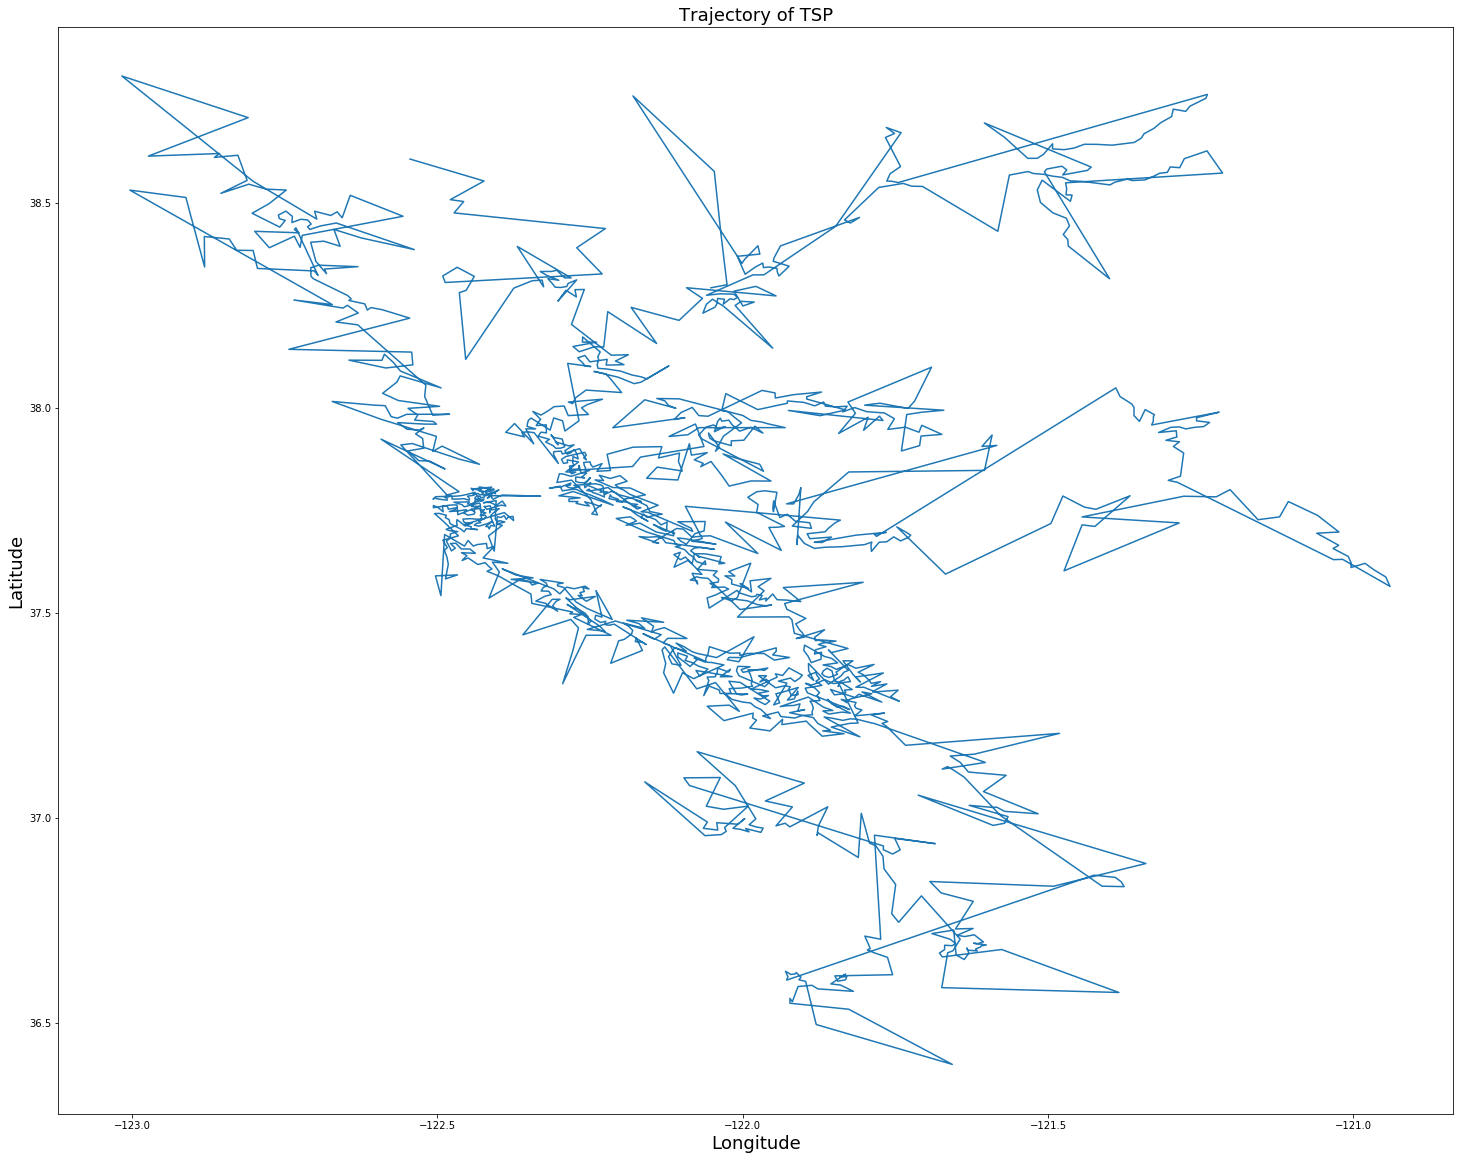

In [31]:
plt.figure(figsize = (25, 20))

plt.plot(longitude, latitude)
plt.xlabel('Longitude', fontsize = 18)
plt.ylabel('Latitude', fontsize = 18)
plt.title('Trajectory of TSP', fontsize = 18)
plt.show()

### Q11

In [32]:
coor_df = map_df.copy()
coor_df = coor_df.iloc[:, [2,3]]
coor_df.head()

,Longitude,Latitude
1,-120.789,36.0716
2,-122.219,37.4696
3,-121.66,37.1505
4,-121.343,38.5731
5,-121.362,38.5544


In [33]:
coor_list = []
for i in range(len(coor_df)):
    coor_list.append([coor_df.iloc[i, 0], coor_df.iloc[i, 1]])
coor_arr = np.asarray(coor_list)
tri = Delaunay(coor_arr)

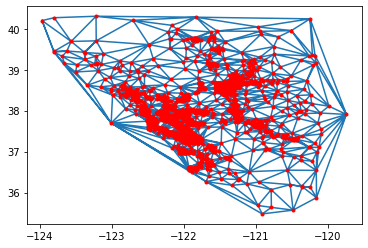

In [34]:
plt.triplot(tri.points[:, 0], tri.points[:, 1], tri.simplices.copy())
plt.triplot(tri.points[:, 0], tri.points[:, 1], 'r.')
#plt.plot(tri.points[:, 0], tri.points[:, 1], 'o')
plt.show()

In [35]:
coor_list_2 = []
# gcc_vertices = gcc.vs()
for v in gcc_vertices:
    coor_list_2.append(list(v['Coordinate']))
coor_arr_2 = np.array(coor_list_2)


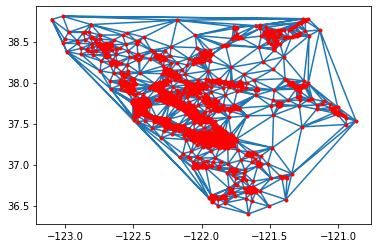

In [36]:
tri_2 = Delaunay(coor_arr_2)
plt.triplot(tri_2.points[:, 0], tri_2.points[:, 1], tri_2.simplices.copy())
plt.triplot(tri_2.points[:, 0], tri_2.points[:, 1],'r.')

plt.show()